# Masking HEALPix datasets

For users who do not want to simulate and fit a full sky map (e.g., to remove confusing regions) or who need patches of a HEALPix map at high resolution, IMAGINE has a Masks class derived from **ObservableDict**.  It also applies the masks correctly not only to the simulation but also the measured data sets and the corresponding observational covariances. 


In [1]:
import numpy as np
import healpy as hp
import imagine as img
import astropy.units as u
import imagine.observables as img_obs
from imagine.fields.hamx import BregLSA, TEregYMW16, CREAna

## Creating a Mask dictionary
First of all, make an example, let's mask out low latitude $|l| < 20^\circ$ pixels and those inside four local loops

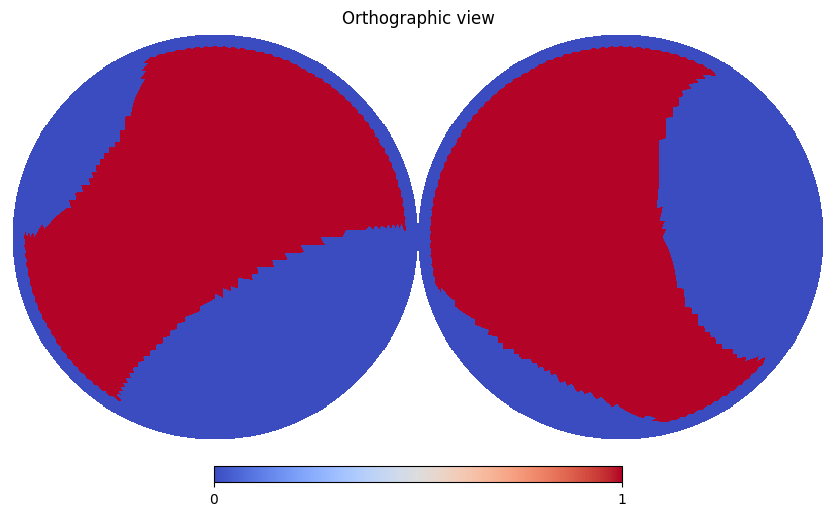

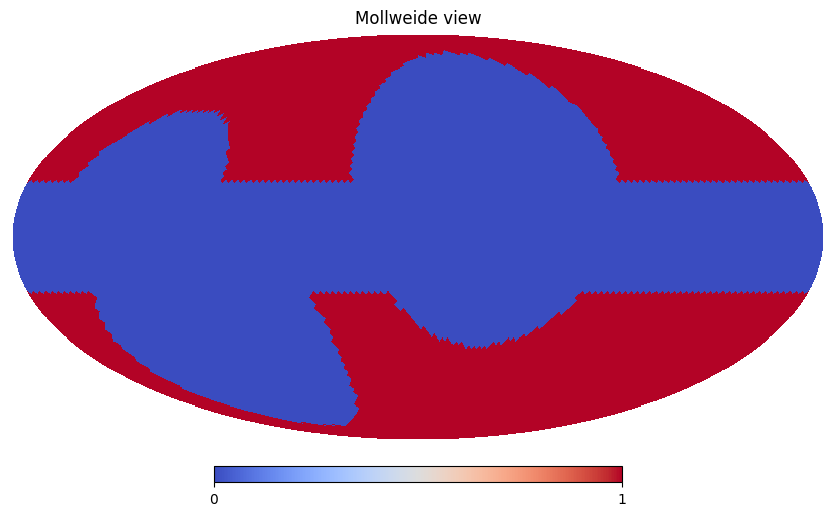

In [2]:
mask_nside = 32

def mask_map_val(_nside,_ipix):
    """Mask loops and latitude"""
    l,b = hp.pix2ang(_nside,_ipix,lonlat=True)
    R = np.pi/180.
    cue = 1
    L = [329,100,124,315]
    B = [17.5,-32.5,15.5,48.5]
    D = [116,91,65,39.5]
    #LOOP I
    if( np.arccos(np.sin(b*R)*np.sin(B[0]*R)+np.cos(b*R)*np.cos(B[0]*R)*np.cos(l*R-L[0]*R))<0.5*D[0]*R ):
        cue = 0
    #LOOP II
    if( np.arccos(np.sin(b*R)*np.sin(B[1]*R)+np.cos(b*R)*np.cos(B[1]*R)*np.cos(l*R-L[1]*R))<0.5*D[1]*R ):
        cue = 0
    #LOOP III
    if( np.arccos(np.sin(b*R)*np.sin(B[2]*R)+np.cos(b*R)*np.cos(B[2]*R)*np.cos(l*R-L[2]*R))<0.5*D[2]*R ):
        cue = 0
    #LOOP IV
    if( np.arccos(np.sin(b*R)*np.sin(B[3]*R)+np.cos(b*R)*np.cos(B[3]*R)*np.cos(l*R-L[3]*R))<0.5*D[3]*R ):
        cue = 0
    #STRIPE
    if(abs(b)<20.):
        cue = 0
    return cue

mask_map = np.zeros(hp.nside2npix(mask_nside))

for i in range(len(mask_map)):
    mask_map[i] = mask_map_val(mask_nside, i)

# Presents the generated mask map  
hp.orthview(mask_map, cmap='coolwarm', rot=(0,90))
hp.mollview(mask_map, cmap='coolwarm')

The procedure to include the above created mask in a *Masks* dictionary is the same as the *Measurements* (at the moment, the is no helper equivalent to the *Dataset*, but this should not be an issue).

In [3]:
masks = img_obs.Masks()
masks.append(name=('sync', 23.0, 32, 'I'), data=np.vstack([mask_map]))

## Applying Masks directly

Typically, after setting the masks, we supply them to the Likelihood and/or Simulator classes, which allow them (see section below) *to be used* in the pipeline run.

Nevertheless, to understand or check what is going on internally, we can apply it ourselves to a given Observable.
To illustrate this, let us first generate a mock synchrotron map using Hammurabi (using the usual trick).

In [4]:
from imagine.simulators import Hammurabi

# Creates empty datasets 
sync_dset = img_obs.SynchrotronHEALPixDataset(data=np.empty(12*32**2)*u.K, 
                                              frequency=23, typ='I')
# Appends them to an Observables Dictionary
fakeMeasureDict = img_obs.Measurements()
fakeMeasureDict.append(dataset=sync_dset)
# Initializes the Simulator with the fake Measurements
simulator = Hammurabi(measurements=fakeMeasureDict)
# Initializes Fields
breg_wmap = BregLSA(parameters={'b0': 6.0, 'psi0': 27.9,
                                'psi1': 1.3, 'chi0': 24.6})
cre_ana = CREAna(parameters={'alpha': 3.0, 'beta': 0.0, 
                             'theta': 0.0,'r0': 5.6, 'z0': 1.2,
                             'E0': 20.5, 'j0': 0.03})
fereg_ymw16 = TEregYMW16(parameters={})

# Produces the mock dataset
maps = simulator([breg_wmap, cre_ana, fereg_ymw16])

ImportError: cannot import name 'Hammurabi' from 'imagine.simulators' (/home/sebastian/Development/PythonProjects/imagine/venv/lib/python3.8/site-packages/imagine/simulators/__init__.py)

We can now inspect how this data looks before the masking takes place 

/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colorm

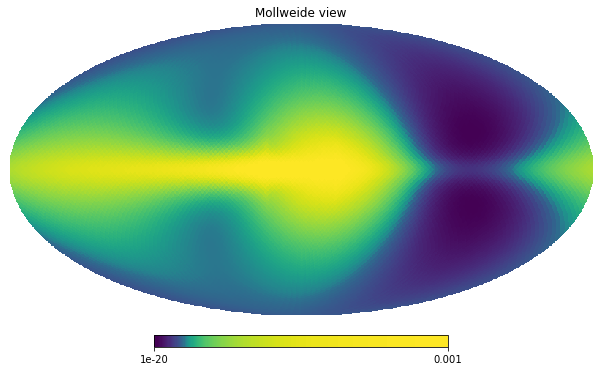

In [ ]:
unmasked_map = maps[('sync', 23.0, 32, 'I')].data[0]
hp.mollview(unmasked_map, norm='hist', min=1e-20, max=1.0e-3)

The `masks` object acts as a function that takes an observable dictionary (i.e. `Measurements`, `Covariances` or `Simulations`) and returns a new `ObservablesDict` with relevant maps already masked.

In [ ]:
# Creates the masked map(s)
new_maps = masks(maps)
# Stores it, for conveniency
masked_map = new_maps[('sync', 23.0, 4941,'I')].data[0]

Applying a mask, however, changes the size of the data array

In [ ]:
print('Masked map size:', masked_map.size)
print('Orignal map size', unmasked_map.size)

Masked map size: 4941
Orignal map size 12288


This is expected: the whole point of masking is not using parts of the data which are unreliable or irrelevant for a particular purpose.

However, if, to check whether things are working correctly, we wish to *look* at masked image, we need to reconstruct it. This means creating a new image including the pixels which we previously have thrown away, as exemplified below:

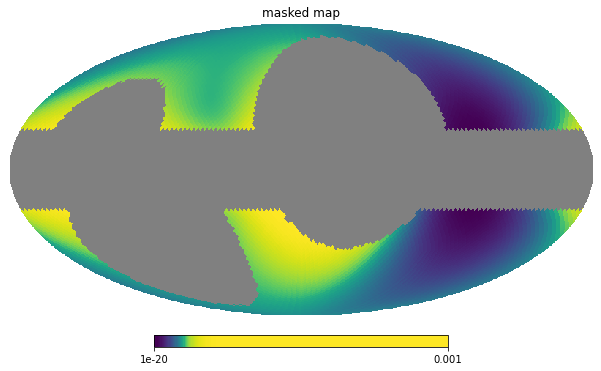

In [ ]:
# Creates an empty array for the results
masked = np.empty(hp.nside2npix(mask_nside))
# Saves each pixel `raw_map` in `masked`, adding "unseen" tags for
# pixels in the mask
idx = 0
for i in range(len(mask_map)):
    if mask_map[i] == 0:
        masked[i] = hp.UNSEEN
    else:
        masked[i] = masked_map[idx]
        idx += 1
# Shows the image   
hp.mollview(masked, norm='hist', min=1e-20, max=1.0e-3, title='masked map')

## Using the Masks

The masks affect (separately) two aspects of the calculation: they can influence the Likelihood object, making it ignoring the masked parts of the maps in the likelihood calculation; and they can change the behaviour of the Simulator object, allowing it to ignore the masked pixels while computing the simulated maps.

### Masks in likelihood calculation

To use the masks in the likelihood calculation, they should be supplied while initializing the *Likelihood* object, as an extra argument, for example:

In [ ]:
likelihood = img.likelihoods.SimpleLikelihood(fakeMeasureDict, mask_dict=masks)

When a mask  is supplied, the likelihood object stores internally only the masked version of the `Measurements`, which can be checked in the following way:

In [ ]:
likelihood.measurement_dict.keys()

dict_keys([('sync', 23, 4941, 'I')])


### Masks with the Hammurabi simulator

To set-up Hammurabi to use masks, it is sufficient to initialize the simulator providing the masks using the `masks` keyword argument. However, there a subtlety: while Hammurabi X does support masks, there is *only a single mask input entry*, which means all outputs will be masked by the same mask. 

Thus, the masks provided to the IMAGINE Hammurabi simulator must cover all Hammurabi-compatible observables and (currently) they must be *identical* (including having the *same resolution*, in the future, however, IMAGINE will support compatible masks of different resolutions to be applied). 

<!-- Later, this will be adjust And the input mask will be treated at pivot resolution, output maps may be in various resolutions by adjusting the input mask into corresponding resolution. It is not trivial in changing mask resolution, for more details please check the hammurabi X wiki. -->



In [ ]:
# Initializing Hammurabi including the masks
simulator = Hammurabi(measurements=fakeMeasureDict, masks=masks)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '32'}


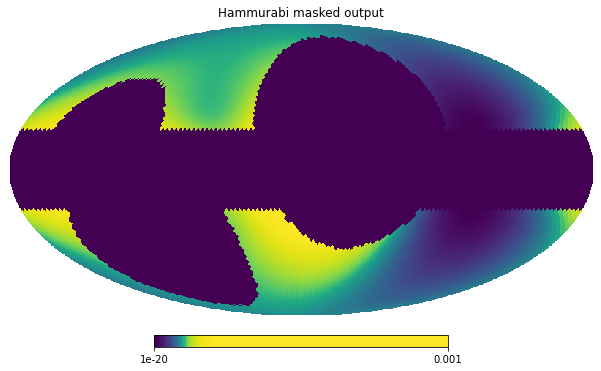

In [ ]:
# Re-runs the simulator which is using the mask internally 
maps = simulator([breg_wmap, cre_ana, fereg_ymw16])
# Shows the new map
hammurabi_masked = maps[('sync', 23.0, 32,'I')].data[0]
hp.mollview(hammurabi_masked, norm='hist', min=1e-20, max=1.0e-3, 
            title='Hammurabi masked output')

We see that, when the masks are used by Hammurabi, the simulator does not do any work on the masked pixels and they receive `0` in the output produced. 